# ResNet(Residual Network) 모델 구현 및 전이 학습

이번에는 **ResNet(Residual Network)**의 구조와 원리를 이해하고, TensorFlow와 PyTorch를 사용하여 직접 구현해보겠습니다.

또한, **전이 학습(Transfer Learning)**을 통해 사전 학습된 ResNet 모델을 불러와 사용하는 방법을 알아보겠습니다.

이를 통해 복잡한 모델을 처음부터 구현하는 것과 사전 학습된 모델을 활용하는 것의 차이점을 확인할 수 있습니다.

## ResNet(Residual Net) 소개

1.1 ResNet이란?
**ResNet(Residual Network)**은 2015년 ILSVRC(ImageNet Large Scale Visual Recognition Competition)에서 우승한 모델로, **3.57%**의 상위-5 오류율을 기록했습니다.

<img src="https://wikidocs.net/images/page/137252/IMG_62347E9C6248-1.jpeg">

- ResNet은 네트워크의 깊이가 깊어질수록 발생하는 기울기 소실(Vanishing Gradient) 문제를 해결하기 위해 Residual Learning이라는 혁신적인 개념을 도입했습니다.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FBfTt7%2FbtqD54pByUv%2FGDoQzU6YSM0cohsGhoMMJk%2Fimg.png">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/ba/ResBlock.png/440px-ResBlock.png">

- 최대 152개의 층으로 이루어진 깊은 신경망을 성공적으로 학습시켰습니다.

  <img src="https://miro.medium.com/max/1200/1*6hF97Upuqg_LdsqWY6n_wg.png">

### 1.2 ResNet의 특징

- Residual Connection(지름길 연결): 입력을 출력에 직접 더해주는 지름길 연결을 사용하여 기울기 소실 문제를 완화합니다.

- Bottleneck 구조: 1x1 합성곱 계층을 사용하여 채널 수를 줄이고 계산 효율성을 높입니다.

- Batch Normalization: 각 합성곱 계층 뒤에 배치 정규화를 적용하여 학습 속도와 안정성을 향상시킵니다.

- 3x3 합성곱: 작은 크기의 커널을 사용하여 매개변수 수를 줄입니다.
깊은 네트워크 학습: 최대 152개의 층으로 이루어진 깊은 신경망을 성공적으로 학습시켰습니다.


## 2. Residual Block 이해

### 2.1 Residual Block 구조
Residual Block은 입력 $x$를 합성곱 계층들을 거친 출력 $F(x)$에 직접 더해주는 구조입니다. 이러한 지름길 연결은 기울기 소실 문제를 완화하고, 더 깊은 네트워크 학습을 가능하게 합니다.

<img src="https://miro.medium.com/max/875/1*6hF97Upuqg_LdsqWY6n_wg.png" alt="Residual Block" style="width: 500px;">

### 2.2 수학적 표현과 장점

### 수학적 표현

- 일반적인 합성곱 신경망은 각 층에서 입력 x를 함수 F(x)를 통해 출력 y로 변환합니다. (y=F(x))
- ResNet에서는 출력 y를 F(x) + x로 정의하여, 입력 x를 그대로 더해줍니다. (y=F(x)+x.)
- 이때 F(x)는 합성곱, 활성화 함수 등을 포함한 **Residual Function**입니다.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/ba/ResBlock.png/440px-ResBlock.png">


### 장점

- 기울기 전파: 지름길 연결을 통해 기울기가 직접 초기 층까지 전파될 수 있어 학습이 용이합니다.
- 표현력 향상: 깊은 네트워크에서도 성능이 향상되며, 모델의 표현력이 증가합니다.
- 매개변수 증가 최소화: 지름길 연결은 추가적인 매개변수를 도입하지 않으므로, 모델의 복잡도를 크게 증가시키지 않습니다.

## 3. TensorFlow를 사용한 ResNet 구현

### 필요한 라이브러리 import

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation,
                                     Add, Input, ZeroPadding2D, MaxPooling2D,
                                     GlobalAveragePooling2D, Dense)
import matplotlib.pyplot as plt

### Residual Block 구현

Residual Block은 두 가지로 나뉩니다.

- Identity Block
    - 입력과 출력의 차원이 동일한 경우 사용됩니다.
- Convolutional Block
    - 입력과 출력의 차원이 다른 경우, 지름길 연결에 1x1 합성곱을 적용하여 차원을 맞춥니다.

### Identity Block 구현

In [ ]:
def identity_block(X, f, filters, stage, block):
    """
    Identity Block: 입력과 출력의 차원이 동일한 경우 사용되는 블록.

    Arguments:
    X -- 입력 텐서, shape = (m, n_H_prev, n_W_prev, n_C_prev)
    f -- 중간 합성곱 층의 필터 크기
    filters -- 정수들의 배열, 각 합성곱 층의 필터 수 [F1, F2, F3]
    stage -- 정수, 현재 블록의 스테이지 (네트워크에서 위치)
    block -- 문자열, 블록의 이름 지정

    Returns:
    X -- Identity Block을 통과한 출력 텐서
    """
    # 필터 수 정의
    F1, F2, F3 = filters

    # 레이어 이름 지정
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base   = 'bn'  + str(stage) + block + '_branch'

    # 입력값 저장
    X_shortcut = X

    # 첫 번째 합성곱 층
    X = Conv2D(F1, (1,1), padding='valid', name=conv_name_base + '2a')(X)
    X = BatchNormalization(name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # 두 번째 합성곱 층
    X = Conv2D(F2, (f,f), padding='same', name=conv_name_base + '2b')(X)
    X = BatchNormalization(name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # 세 번째 합성곱 층
    X = Conv2D(F3, (1,1), padding='valid', name=conv_name_base + '2c')(X)
    X = BatchNormalization(name=bn_name_base + '2c')(X)

    # 지름길 연결과 합성곱 출력 합산
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

### Convolutional Block 구현

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Convolutional Block: 입력과 출력의 차원이 다른 경우 사용되는 블록.

    Arguments:
    X -- 입력 텐서, shape = (m, n_H_prev, n_W_prev, n_C_prev)
    f -- 중간 합성곱 층의 필터 크기
    filters -- 정수들의 배열, 각 합성곱 층의 필터 수 [F1, F2, F3]
    stage -- 정수, 현재 블록의 스테이지 (네트워크에서 위치)
    block -- 문자열, 블록의 이름 지정
    s -- 정수, 첫 번째 합성곱 층의 스트라이드

    Returns:
    X -- Convolutional Block을 통과한 출력 텐서
    """
    # 필터 수 정의
    F1, F2, F3 = filters

    # 레이어 이름 지정
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base   = 'bn'  + str(stage) + block + '_branch'

    # 입력값 저장
    X_shortcut = X

    # 첫 번째 합성곱 층
    X = Conv2D(F1, (1,1), strides=(s,s), padding='valid',
               name=conv_name_base + '2a')(X)
    X = BatchNormalization(name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # 두 번째 합성곱 층
    X = Conv2D(F2, (f,f), strides=(1,1), padding='same',
               name=conv_name_base + '2b')(X)
    X = BatchNormalization(name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # 세 번째 합성곱 층
    X = Conv2D(F3, (1,1), strides=(1,1), padding='valid',
               name=conv_name_base + '2c')(X)
    X = BatchNormalization(name=bn_name_base + '2c')(X)

    # 지름길 연결에 1x1 합성곱 적용
    X_shortcut = Conv2D(F3, (1,1), strides=(s,s), padding='valid',
                        name=conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_name_base + '1')(X_shortcut)

    # 지름길 연결과 합성곱 출력 합산
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

### 전체 모델 구성
ResNet50 모델을 구성합니다.

In [ ]:
def ResNet50(input_shape=(224, 224, 3), classes=1000):
    """
    ResNet50 모델을 구성하는 함수.

    Arguments:
    input_shape -- 입력 데이터의 shape
    classes -- 분류할 클래스 수

    Returns:
    model -- Keras 모델 인스턴스
    """
    # 입력 레이어
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3,3))(X_input)

    # 초기 합성곱 및 맥스 풀링
    X = Conv2D(64, (7,7), strides=(2,2), name='conv1')(X)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3,3), strides=(2,2))(X)

    # 단계별 Residual Block 구성
    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256],
                            stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128,128,512],
                            stage=3, block='a', s=2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    X = identity_block(X, 3, [128,128,512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256,256,1024],
                            stage=4, block='a', s=2)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='d')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='e')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512,512,2048],
                            stage=5, block='a', s=2)
    X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
    X = identity_block(X, 3, [512,512,2048], stage=5, block='c')

    # 평균 풀링
    X = GlobalAveragePooling2D(name='avg_pool')(X)

    # 출력층
    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)

    # 모델 생성
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

# 모델 생성
resnet = ResNet50()

- 입력 레이어: 입력 이미지의 크기를 (224, 224, 3)으로 설정합니다.
- Zero-Padding: 입력 이미지의 크기를 유지하기 위해 적용합니다.
- 초기 합성곱 및 맥스 풀링: 이미지의 특징을 추출하고 크기를 줄입니다.
- Residual Blocks: 총 5개의 스테이지로 구성되며, 각 스테이지는 Convolutional - Block과 여러 개의 Identity Block으로 이루어집니다.
- Global Average Pooling: 공간 차원을 평균화하여 1차원 벡터로 변환합니다.
- 출력층: softmax 활성화 함수를 사용하여 클래스별 확률을 출력합니다.

### 모델 요약

In [ ]:
resnet.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 64)   │          9,472 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_conv1                  │ (None, 112, 112, 64)   │            256 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ bn_conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 55, 55, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2a (Conv2D)   │ (None, 55, 55, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2a             │ (None, 55, 55, 64)     │            256 │ res2a_branch2a[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 55, 55, 64)     │              0 │ bn2a_branch2a[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2b (Conv2D)   │ (None, 55, 55, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2b             │ (None, 55, 55, 64)     │            256 │ res2a_branch2b[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 55, 55, 64)     │              0 │ bn2a_branch2b[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch2c (Conv2D)   │ (None, 55, 55, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ res2a_branch1 (Conv2D)    │ (None, 55, 55, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch2c             │ (None, 55, 55, 256)    │          1,024 │ res2a_branch2c[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn2a_branch1              │ (None, 55, 55, 256)    │          1,024 │ res2a_branch1[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

- ResNet50은 약 2천 5백만 개의 파라미터를 가지고 있습니다.

## 4. PyTorch를 사용한 ResNet 구현

### 4.1 필요한 라이브러리 Import

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### 4.2 Bottleneck Block 구현

- Basic Block: ResNet18과 ResNet34에서 사용되는 구조입니다.

- Bottleneck Block: ResNet50, ResNet101, ResNet152에서 사용되는 블록입니다. 1x1 합성곱을 사용하여 채널 수를 조절합니다.

### Bottleneck Block 구현

In [ ]:
class Bottleneck(nn.Module):
    expansion = 4  # 출력 채널 수를 늘리는 배수

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        # 1x1 Conv (채널 수 감소)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # 3x3 Conv (특징 추출)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        # 1x1 Conv (채널 수 복원)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        # 지름길 연결
        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        # 첫 번째 합성곱
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # 두 번째 합성곱
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        # 세 번째 합성곱
        out = self.conv3(out)
        out = self.bn3(out)

        # 지름길 연결
        if self.downsample is not None:
            identity = self.downsample(x)

        # 출력과 지름길 연결 합산
        out += identity
        out = self.relu(out)

        return out

- expansion: 출력 채널 수를 늘리는 데 사용되는 배수. 여기서는 expansion = 4입니다.
- downsample: 입력과 출력의 크기가 다를 때, 지름길 연결에 1x1 합성곱을 적용하여 차원을 맞춥니다.

### 전체 모델 구성

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        # 초기 합성곱 계층
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # 맥스 풀링
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 단계별 Residual Block 구성
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # 평균 풀링 및 출력층
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            # 지름길 연결에 1x1 합성곱 적용
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        # 첫 번째 블록
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        # 나머지 블록
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # 초기 계층
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # 단계별 블록
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # 평균 풀링 및 출력층
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])

# 모델 생성
resnet = ResNet50()

- ResNet 클래스는 ResNet 모델을 구현합니다.
- _make_layer 함수는 주어진 블록을 여러 개 쌓아 레이어를 구성합니다.
- ResNet50 함수는 Bottleneck 블록과 각 단계별 블록 수를 지정하여 ResNet50 모델을 생성합니다.

### 모델 요약

In [ ]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

summary(resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

- ResNet50은 약 2천 5백만 개의 파라미터를 가지고 있습니다.

## 5. 전이 학습을 통한 사전 학습된 ResNet 모델 사용

### 5.1 TensorFlow에서의 전이 학습

### 필요한 라이브러리 import

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

### 사전 학습된 ResNet50 모델 로드

In [ ]:
# 사전 학습된 ResNet50 모델 로드
resnet_pretrained = ResNet50(include_top=True, weights='imagenet')

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


- include_top=True로 설정하여 완전 연결 계층까지 포함합니다.
- weights='imagenet'로 설정하여 ImageNet 데이터셋으로 학습된 가중치를 불러옵니다.

### 이미지 불러오기 및 전처리

--2024-10-25 07:24:25--  https://upload.wikimedia.org/wikipedia/commons/4/4d/Apis_mellifera_Western_honey_bee.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2421052 (2.3M) [image/jpeg]
Saving to: ‘bee.jpg’

bee.jpg             100%[===================>]   2.31M  --.-KB/s    in 0.1s    

2024-10-25 07:24:25 (15.9 MB/s) - ‘bee.jpg’ saved [2421052/2421052]



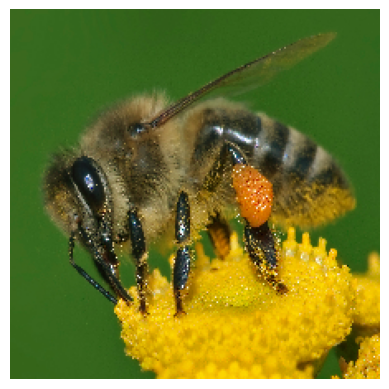

In [ ]:
# 이미지 다운로드 (예: 벌 사진)
!wget -O bee.jpg https://upload.wikimedia.org/wikipedia/commons/4/4d/Apis_mellifera_Western_honey_bee.jpg

# 이미지 로드 및 전처리
img = image.load_img('bee.jpg', target_size=(224, 224))
plt.imshow(img)
plt.axis('off')
plt.show()

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

- 이미지를 불러와서 모델의 입력 크기에 맞게 조정합니다.
- preprocess_input 함수를 사용하여 전처리를 수행합니다.


### 예측 및 결과 해석


In [ ]:
preds = resnet_pretrained.predict(x)
print('Predicted:', decode_predictions(preds, top=5)[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n02206856', 'bee', 0.9990978), ('n03530642', 'honeycomb', 0.0005626679), ('n02190166', 'fly', 0.00014306474), ('n02727426', 'apiary', 0.00010191268), ('n02219486', 'ant', 5.7411286e-05)]


- 예측 결과:
    - 가장 높은 확률로 bee(벌)로 분류되었습니다

## 5.2 PyTorch에서의 전이 학습

### 필요한 라이브러리 import


In [ ]:
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import torch

### 사전 학습된 ResNet50 모델 로드

In [ ]:
# 사전 학습된 ResNet50 모델 로드
resnet_pretrained = models.resnet50(pretrained=True)
resnet_pretrained.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 124MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

- pretrained=True로 설정하여 ImageNet 가중치를 불러옵니다.
- eval() 메서드를 호출하여 모델을 평가 모드로 전환합니다.

### 이미지 불러오기 및 전처리

In [ ]:
# 이미지 로드
img = Image.open('bee.jpg')

# 이미지 전처리
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet의 평균
        std=[0.229, 0.224, 0.225]    # ImageNet의 표준편차
    )
])

img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

- transforms를 사용하여 이미지에 대한 일련의 전처리를 정의합니다.
- 이미지를 텐서로 변환하고, 정규화합니다.

### 예측 및 결과 해석

In [ ]:
with torch.no_grad():
    out = resnet_pretrained(batch_t)

# ImageNet의 클래스 인덱스 로드
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

with open('imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

# 예측 결과 확인
probabilities = torch.nn.functional.softmax(out[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)

for i in range(top5_prob.size(0)):
    print(classes[top5_catid[i]], top5_prob[i].item())

--2024-10-25 07:24:37--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2024-10-25 07:24:37 (90.6 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]

bee 0.9921040534973145
fly 0.004013645462691784
honeycomb 0.0023409000132232904
apiary 0.0006286114221438766
ant 0.0004165647551417351


### 예측 결과

- 가장 높은 확률로 bee(벌)로 분류되었습니다.


## 6. TensorFlow와 PyTorch 구현 비교

- 모델 구현 방식:

    - TensorFlow는 Keras의 함수형 API를 사용하여 모델을 구성하였으며, Add 레이어를 사용하여 Residual Connection을 구현했습니다.
    - PyTorch는 클래스 기반으로 모델을 구현하였으며, 직접 연산을 통해 Residual Connection을 구현했습니다.

- Residual Block 구현:

    - 두 프레임워크 모두 Residual Block을 별도의 함수나 클래스로 정의하여 코드의 재사용성과 가독성을 높였습니다.
    - TensorFlow에서는 identity_block과 convolutional_block으로 구분하여 구현하였고, PyTorch에서는 Bottleneck 클래스를 사용하였습니다.

- 전이 학습 사용 방법:

    - TensorFlow는 tensorflow.keras.applications 모듈을 사용하여 사전 학습된 모델을 불러옵니다.
    - PyTorch는 torchvision.models를 사용하여 사전 학습된 모델을 불러옵니다.
    - 두 프레임워크 모두 간단한 코드로 사전 학습된 모델을 사용할 수 있습니다.

- 이미지 전처리:

    - 두 프레임워크 모두 모델에 맞는 입력 크기와 정규화를 적용해야 합니다.
    - TensorFlow는 preprocess_input 함수를 제공하여 전처리를 쉽게 수행할 수 있습니다.
    - PyTorch는 transforms를 사용하여 전처리를 구성합니다.

- 예측 결과 해석:

    - TensorFlow는 decode_predictions 함수를 제공하여 예측 결과를 해석합니다.
    - PyTorch는 별도로 클래스 인덱스 파일을 불러와서 매핑해야 합니다.

## 7. 결론

- 이번에는 ResNet의 구조와 특징을 이해하고, TensorFlow와 PyTorch에서 직접 구현해보았습니다.
- 그리고, Residual Block의 구현을 통해 모델의 핵심 아이디어를 살펴보았습니다.
- 또한, 전이 학습을 통해 사전 학습된 모델을 불러와 사용하는 방법을 알아보았습니다.
- 두 프레임워크 모두 사전 학습된 모델을 쉽게 사용할 수 있으며, 이를 통해 모델 학습 시간을 절약하고 높은 성능을 얻을 수 있습니다.
- TensorFlow와 PyTorch의 모델 구현 방식과 사용 방법을 비교하여 이해함으로써, 상황에 맞는 프레임워크를 선택하고 활용할 수 있습니다.

## 8. 과제

### 과제 1: ResNet 모델 구조 타이핑 및 이해

### 목표
    - ResNet 모델의 구조를 직접 타이핑해보면서 각 레이어가 어떻게 쌓이는지 연습해보세요.

## 방법
    - TensorFlow 또는 PyTorch를 선택하여 ResNet50 모델의 코드를 직접 타이핑해보세요.
    - 타이핑 하는 과정에서 각 레이어의 역할과 파라미터 수를 주석으로 달아가며 작업을 해보세요.
    - 모델의 summary를 출력하여 구조를 확인하고, 각 층의 출력 형태와 파라미터 수를 분석하세요.

### 과제 2: ResNet에 대한 추가 조사 및 정리

### 목표
    - ResNet에 대해 추가로 연구하고, 해당 모델에 대해 정리해보세요.

### 방법
    - ResNet의 역사와 발전 과정에 대해 조사해보세요.
    - ResNet의 다양한 변형(ResNet18, ResNet34, ResNet101, ResNet152 등)에 대해 알아보세요.
    - ResNet이 다른 CNN 모델과 비교했을 때 가지는 장단점을 정리해서 노션 페이지에 공유해주세요.

### 과제 3: 사전 학습된 ResNet 모델을 사용한 분류 실습

### 목표
    - 사전 학습된 ResNet 모델을 사용하여 자신만의 이미지를 분류해보세요.

### 방법
    - TensorFlow 또는 PyTorch를 선택하여 사전 학습된 ResNet50 모델을 불러옵니다.
    - 분류하고자 하는 이미지를 선택하여 전처리합니다.
    - 모델을 사용하여 이미지를 분류하고, 예측 결과를 해석해보시고, 노션 페이지에 공유해주세요.

### Reference

- [ResNet, ResNet의 확장(레이어 152개 이하)](https://wikidocs.net/137252)